In [1]:
# load CIFAR-100 dataset
from torchvision import datasets
import torchvision.models as models
from torchvision.transforms import transforms
# import neccessary libraries
import os
import sys
import json
import requests
from tqdm import tqdm
import time
import datetime
import logging
import logging.handlers
import torch
import pandas as pd
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import os
from datasets import load_dataset
import torch.nn.parallel
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torch.utils.data import Dataset

/home/mingxu/miniconda3/envs/ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
transform_ori = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 标准化
])

class CustomCIFAR100(Dataset):
    def __init__(self, root, train, download, transform=None):
        # 原始数据集
        self.original_dataset = datasets.CIFAR100(root=root, train=train, download=download, transform=transform_ori)
        # 只在增强数据集上应用变换
        self.augmented_dataset = datasets.CIFAR100(root=root, train=train, download=False, transform=transform)

    def __len__(self):
        # 数据集大小翻倍
        return 2 * len(self.original_dataset)

    def __getitem__(self, idx):
        if idx % 2 == 0:  # 偶数索引返回增强数据
            return self.augmented_dataset[idx // 2]
        else:  # 奇数索引返回原始数据
            return self.original_dataset[idx // 2]

# 定义增强变换
augmentations = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    transforms.RandomRotation(10),
    transforms.RandomCrop(32, padding=4),
    transforms.Compose([transforms.RandomPerspective(distortion_scale=0.5)]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])



# 加载数据集
train_dataset = CustomCIFAR100(root='./data', train=True, download=True, transform=transform_ori)
test_dataset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_ori)

# 首先获取类别信息
classes = train_dataset.original_dataset.classes
print(classes)

# 初始化类计数器
class_counts = {i: 0 for i in range(100)}

# 遍历原始数据集的目标标签，每找到一个标签，计数加2（原始和增强）
for label in train_dataset.original_dataset.targets:
    class_counts[label] += 2  # 因为我们添加了原始和对应的增强图像

# 打印每个类别的样本数
for i in range(100):
    print(f"Class {i} has {classes[i]}, count: {class_counts[i]} samples")


Files already downloaded and verified
Files already downloaded and verified
['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tracto

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

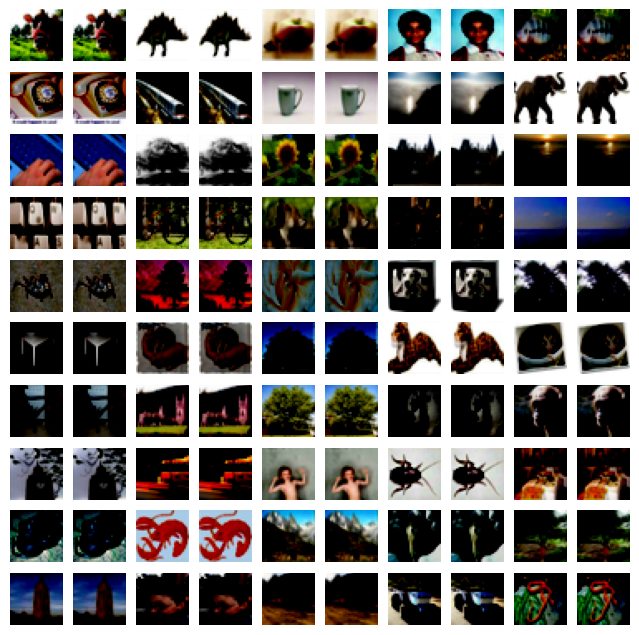

In [4]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
columns = 10
rows = 10
for i in range(1, columns * rows + 1):
    img, label = train_dataset[i-1]  # 从自定义数据集获取图像和标签
    fig.add_subplot(rows, columns, i)
    if isinstance(img, torch.Tensor):
        # 如果图像是张量，需要转置维度
        plt.imshow(img.permute(1, 2, 0))
    else:
        # 如果图像是 PIL 图像，直接显示
        plt.imshow(img)
    plt.axis('off')
plt.show()


In [5]:
# batch_size = 128 load dataset
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [6]:

import wandb
import random
wandb.init(
    project="DL_Classification_CIFAR-100",
    config={
    "learning_rate": 5e-3,
    "architecture": "ResNet_ViT",
    "dataset": "CIFAR-100",
    "epochs": 50,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mingxu_zhang (mingxus-team). Use `wandb login --relogin` to force relogin


In [7]:
# print the train and test dataset sizes
print('Train: ', len(train_loader.dataset))
print('Test: ', len(test_loader.dataset))
# print the train and test batch sizes
print('Total Batch: ', len(train_loader))
print('Total Batch: ', len(test_loader))

Train:  100000
Test:  10000
Total Batch:  1563
Total Batch:  157


In [8]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=100, dropout_rate=0.5):
        super(ResNet, self).__init__()
        self.in_channels = 32
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(32)
        self.layer1 = self.make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 256, num_blocks[3], stride=2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(256, num_classes)

    def make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn(self.conv(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.dropout(out) 
        out = self.fc(out)
        return out
        
    def evaluate(self, test_loader, criterion, use_cuda):
        # calculate the accuracy on the test set
        model.eval()
        test_loss = 0.0
        class_correct = list(0. for i in range(100))
        class_total = list(0. for i in range(100))
        for data, target in tqdm(test_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        test_loss = test_loss/len(test_loader.dataset)
        for i in range(10):
            if class_total[i] > 0:
                # log accuracy of each class
                wandb.log({"acc_{}".format(classes[i]): class_correct[i] / class_total[i]})
                #print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))  
        #wandb log the average acc
        wandb.log({"acc": np.sum(class_correct) / np.sum(class_total)})
        # print average acc
        print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
        

    def train_model(model, train_loader, valid_loader, epochs, optimizer, criterion, use_cuda, save_path):
        valid_loss_min = np.Inf
        count = 0
        for epoch in tqdm(range(1, epochs+1)):
            train_loss = 0.0
            valid_loss = 0.0
            model.train()
            for data, target in train_loader:
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()*data.size(0)
            model.eval()
            for data, target in valid_loader:
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                output = model(data)
                loss = criterion(output, target)
                valid_loss += loss.item()*data.size(0)
            train_loss = train_loss/len(train_loader.sampler)
            valid_loss = valid_loss/len(valid_loader.sampler)
            model.evaluate( valid_loader, criterion, use_cuda)
            wandb.log({"training_loss": train_loss, "val_loss": valid_loss})  

            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, valid_loss))
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss
                count = 0
            else :
                count = count + 1
                if count > 4:
                    break




    def predict(model, test_loader, use_cuda):
        model.eval()
        test_preds = torch.LongTensor()
        use_cuda = torch.cuda.is_available()
        for i, data in tqdm(test_loader):
            if use_cuda:
                data = data.cuda()
            output = model(data)
            preds = output.cpu().data.max(1, keepdim=True)[1]
            test_preds = torch.cat((test_preds, preds), dim=0)
        return test_preds


In [9]:
# 输出模型的架构

# model = ResNet(ResidualBlock, [5, 6, 7, 8])
# print(model)

In [10]:
# load model
# model.load_state_dict(torch.load('ResNet_baseline_model.pt'))

In [11]:
# 前三层作为特征提取器 输出特征灰度图
'''
model = nn.Sequential(*list(model.children())[:-3])
model.eval()
# 提取第一条测试数据的特征
data, target = next(iter(test_loader))
use_cuda = torch.cuda.is_available()
if use_cuda:
    data, target = data.cuda(), target.cuda()
    model = model.cuda()  # Move the model to GPU
output = model(data)
# 输出特征图
output = output.cpu().data.numpy()
output = output[0, :, :, :]
output = output - np.min(output)
output = output / np.max(output)
plt.imshow(output[0], cmap='gray')
plt.axis('off')
plt.show()
'''

"\nmodel = nn.Sequential(*list(model.children())[:-3])\nmodel.eval()\n# 提取第一条测试数据的特征\ndata, target = next(iter(test_loader))\nuse_cuda = torch.cuda.is_available()\nif use_cuda:\n    data, target = data.cuda(), target.cuda()\n    model = model.cuda()  # Move the model to GPU\noutput = model(data)\n# 输出特征图\noutput = output.cpu().data.numpy()\noutput = output[0, :, :, :]\noutput = output - np.min(output)\noutput = output / np.max(output)\nplt.imshow(output[0], cmap='gray')\nplt.axis('off')\nplt.show()\n"

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=129, patch_size=8, emb_size=768):
        super().__init__()
        self.proj = nn.Conv1d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # print("In Patch Embedding forward method")
        # print("before patch embedding size:", x.size())
        x = self.proj(x)  # 卷积操作
        # print("after proj size:", x.size())

        x = x.transpose(1, 2)  # 将特征维度与序列维度交换
        # print("after transpose size:", x.size())
        # print("after patch embedding")
        return x




class TransformerEncoder(nn.Module):
    def __init__(self, emb_size=768, depth=12, n_heads=12, ff_hidden=3072):
        super().__init__()
        layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=n_heads, dim_feedforward=ff_hidden, batch_first=True, norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, num_layers=depth)

    def forward(self, x):
        x = self.encoder(x)
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32*32, patch_size=8, emb_size=768):
        super().__init__()
        self.patch_embedding = PatchEmbedding(patch_size=patch_size, emb_size=emb_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        self.position_embedding = nn.Parameter(torch.randn((img_size // patch_size) ** 2 + 1, emb_size))
        self.transformer = TransformerEncoder(emb_size=emb_size)
        self.to_cls_token = nn.Identity()

    def forward(self, x):
        # print("In Vision Transformer forward method")
        #b = x.shape[0]
        #x = self.patch_embedding(x)
        #cls_token = self.cls_token.expand(b, -1, -1)  # Adjusting cls_token to match batch size of x
        #print("x size:", x.size())
        #print("cls_token size:", cls_token.size())      
        #x = torch.cat((cls_token, x), dim=1)  # [B, 1+N, E]
        #print("After cat size:", x.size())
        #x = x + self.position_embedding[:x.size(1), :]
        #print("After adding position embedding size:", x.size())
        x = self.transformer(x)
        #x = self.to_cls_token(x[:, 0])
        # print("After Vision Transformer")

        return x

class HybridResNetViT(nn.Module):
    def __init__(self, transformer, num_classes=100, emb_size=768, patch_size=8):
        super(HybridResNetViT, self).__init__()
        resnet = ResNet(ResidualBlock, [5, 6, 7, 8])
        resnet.load_state_dict(torch.load('ResNet_baseline_model_enhance.pt'))
        for param in resnet.parameters():
            param.requires_grad = False
        self.resnet_feature_extractor = nn.Sequential(*list(resnet.children())[:-2])

        self.transformer = transformer
        self.classifier = nn.Linear(emb_size, num_classes)
        
        # 新增：用于调整patches尺寸的全连接层
        self.patch_dim_transform = nn.Linear(16, emb_size)
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_size))
        num_patches = ((32*32 // patch_size) ** 2)
        self.position_embedding = nn.Parameter(torch.randn(num_patches + 1, emb_size))
        self.to_cls_token = nn.Identity()

    def forward(self, x):
        # print("Input Shape:", x.shape)
        features = self.resnet_feature_extractor(x)
        # print("Feature Map Shape:", features.shape)
        patches = self._preprocess_features(features)
        # print("before transform Patches Shape:", patches.shape)
        patches = self.patch_dim_transform(patches)  # 调整patches的维度
        # print("after transform Patches Shape:", patches.shape)
        
        batch_size = patches.size(0)
        cls_token = self.cls_token.expand(batch_size, -1, -1)
        # print("cls_token size:", cls_token.size())
        
        x = torch.cat((cls_token, patches), dim=1)
        # print("After cat size:", x.size())
        
        x = x + self.position_embedding[:x.size(1), :]
        # print("After adding position embedding size:", x.size())
        
        x = self.transformer(x)
        # print("After transformer size:", x.size())
        x = self.to_cls_token(x[:, 0])
        # print("After to_cls_token size:", x.size())
        x = self.classifier(x)
        # print("After classifier size:", x.size())
        
        return x
    
    def _preprocess_features(self, features):
        batch_size, channels, height, width = features.size()
        patch_size = min(height, width, 8)  # Ensure the patch size does not exceed feature dimensions

        if height < patch_size or width < patch_size:
            raise ValueError("Feature map size is too small for the given patch size.")

        features = features.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
        features = features.contiguous().view(batch_size, channels, -1, patch_size * patch_size)
        features = features.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, patch_size * patch_size)

        return features


    def evaluate(self, test_loader, criterion, use_cuda, index):
        # calculate the accuracy on the test set
        self.eval()
        test_loss = 0.0
        class_correct = list(0. for i in range(100))
        class_total = list(0. for i in range(100))
        for data, target in tqdm(test_loader):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            output = hybrid_model(data)
            loss = criterion(output, target)
            test_loss += loss.item()*data.size(0)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not use_cuda else np.squeeze(correct_tensor.cpu().numpy())
            for i in range(len(target.data)):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1
        test_loss = test_loss/len(test_loader.dataset)
        for i in range(100):
            if class_total[i] > 0:
                # log accuracy of each class
                # wandb.log({"acc_{}".format(classes[i]): class_correct[i] / class_total[i]})
                wandb.log({"acc_model_{}".format(index): class_correct[i] / class_total[i]})
                #print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], np.sum(class_correct[i]), np.sum(class_total[i])))
            else:
                print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))  
        #wandb log the average acc
        # wandb.log({"acc": np.sum(class_correct) / np.sum(class_total)})
        # print average acc
        print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * np.sum(class_correct) / np.sum(class_total), np.sum(class_correct), np.sum(class_total)))
 
    def train_model(self, train_loader, valid_loader, epochs, optimizer, criterion, use_cuda, save_path):
        valid_loss_min = np.Inf
        for epoch in range(1, epochs + 1):
            train_loss = 0.0
            valid_loss = 0.0
            self.train()
            cnt = 0
            for data, target in tqdm(train_loader):
                cnt = cnt + 1
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = self(data)
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=0.1)  # Add gradient clipping here
                optimizer.step()
                # print(f'Batch: {cnt} \tTraining Loss: {loss.item():.6f}')
                train_loss += loss.item() * data.size(0)
            # self.evaluate(valid_loader, criterion, use_cuda)  # Changed to self.evaluate
            train_loss = train_loss / len(train_loader.dataset)
            valid_loss = valid_loss / len(valid_loader.dataset)
            wandb.log({"training_loss": train_loss, "val_loss": valid_loss})  
            print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')
            if valid_loss <= valid_loss_min:
                print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model ...')
                torch.save(self.state_dict(), save_path)
                valid_loss_min = valid_loss
            torch.save(hybrid_model.state_dict(), save_path + str(epoch%5))


    def predict(model, test_loader, use_cuda):
        model.eval()  # Ensure the model is in evaluation mode
        predictions = []
        with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
            for data, _ in tqdm(test_loader):
                if use_cuda:
                    data = data.cuda()  # Move data to GPU if CUDA is enabled
                output = model(data)
                _, pred = torch.max(output, 1)  # Get the index of the max log-probability
                pred = pred.cpu().numpy() if use_cuda else pred.numpy()  # Move data to CPU if CUDA is used
                predictions.extend(pred)
        return predictions

    def predict_poss(model, test_loader, use_cuda):
        model.eval()  # Ensure the model is in evaluation mode
        probabilities = []
        with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
            for data, _ in tqdm(test_loader):
                if use_cuda:
                    data = data.cuda()  # Move data to GPU if CUDA is enabled

                output = model(data)
                prob = F.softmax(output, dim=1)  # Compute the probability distribution over classes

                if use_cuda:
                    prob = prob.cpu()  # Move data to CPU if CUDA is used

                probabilities.append(prob.numpy())  # Store the probabilities

        # 使用 np.vstack 以确保即使批量大小不同也能正确合并
        return np.vstack(probabilities)

In [ ]:
# 实例化 ResNet 和 Vision Transformer

# resnet_model = ResNet(ResidualBlock, [5, 6, 7, 8])  # 假设已经定义
# resnet_model.load_state_dict(torch.load('ResNet_baseline_model.pt'))
vit_model = VisionTransformer( patch_size=8, emb_size=768)

# 实例化混合模型
hybrid_model = HybridResNetViT( transformer=vit_model, num_classes=100)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')  # Specify GPU1 if CUDA is available
# 设置设备
hybrid_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.005, weight_decay=1e-5)
# 调用训练函数，注意传递 use_cuda 作为关键字参数
HybridResNetViT.train_model(self=hybrid_model, train_loader=train_loader, valid_loader=test_loader, epochs=50, optimizer=optimizer, criterion=criterion, use_cuda=use_cuda, save_path='ViT_baseline_model.pth')


In [13]:

# load the model
# 实例化 ResNet 和 Vision Transformer

# resnet_model = ResNet(ResidualBlock, [5, 6, 7, 8])  # 假设已经定义
# resnet_model.load_state_dict(torch.load('ResNet_baseline_model.pt'))
vit_model = VisionTransformer( patch_size=8, emb_size=768)

# 实例化混合模型
hybrid_model = HybridResNetViT( transformer=vit_model, num_classes=100)

use_cuda = torch.cuda.is_available()
if use_cuda:
    hybrid_model = hybrid_model.cuda()
    
criterion = nn.CrossEntropyLoss()
hybrid_model.load_state_dict(torch.load('ViT_baseline_model.pth'))
# evaluate the model
hybrid_model.evaluate(test_loader, criterion, use_cuda, 'ResNet_ViT_baseline_without_augmentation')


100%|██████████| 157/157 [00:38<00:00,  4.08it/s]

Test Accuracy (Overall): 52% (5299/10000)


In [13]:
vit_model = VisionTransformer( patch_size=8, emb_size=768)
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
criterion = nn.CrossEntropyLoss()
model0 = HybridResNetViT( transformer=vit_model, num_classes=100)
model1 = HybridResNetViT( transformer=vit_model, num_classes=100)
model2 = HybridResNetViT( transformer=vit_model, num_classes=100)
model3 = HybridResNetViT( transformer=vit_model, num_classes=100)
model4 = HybridResNetViT( transformer=vit_model, num_classes=100)

use_cuda = torch.cuda.is_available()
if use_cuda:
    model0 = model0.cuda()
    model1 = model1.cuda()
    model2 = model2.cuda()
    model3 = model3.cuda()
    model4 = model4.cuda()

# load model
model0.load_state_dict(torch.load('ViT_baseline_model0.pth'))
model1.load_state_dict(torch.load('ViT_baseline_model1.pth'))
model2.load_state_dict(torch.load('ViT_baseline_model2.pth'))
model3.load_state_dict(torch.load('ViT_baseline_model3.pth'))
model4.load_state_dict(torch.load('ViT_baseline_model4.pth'))

<All keys matched successfully>

In [ ]:
model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()

test_preds0 = torch.tensor(model0.predict(test_loader, use_cuda), dtype=torch.long)
test_preds1 = torch.tensor(model1.predict(test_loader, use_cuda), dtype=torch.long)
test_preds2 = torch.tensor(model2.predict(test_loader, use_cuda), dtype=torch.long)
test_preds3 = torch.tensor(model3.predict(test_loader, use_cuda), dtype=torch.long)
test_preds4 = torch.tensor(model4.predict(test_loader, use_cuda), dtype=torch.long)

stacked_preds = torch.stack([test_preds0, test_preds1, test_preds2, test_preds3, test_preds4], dim=0)

# Apply torch.mode to find the most common prediction along the stacked dimension
test_preds = torch.mode(stacked_preds, dim=0).values

# Ensure that the dataset has an attribute 'targets' or adjust according to your dataset structure
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
for i in range(len(test_loader.dataset.targets)):
    label = test_loader.dataset.targets[i]
    class_correct[label] += int(test_preds[i].item() == label)

    class_total[label] += 1

# Log ensemble accuracies to wandb and print them
for i in range(100):
    if class_total[i] > 0:
        wandb.log({"ViT_acc_ensemble_voting5": class_correct[i] / class_total[i]})
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % i)

# Calculate and print overall accuracy
print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * sum(class_correct) / sum(class_total), sum(class_correct), sum(class_total)))


In [15]:
# 确保模型在评估模式

model0.eval()
model1.eval()
model2.eval()
model3.eval()
model4.eval()

# 获取每个模型的概率预测
prob_preds0 = np.array(model0.predict_poss(test_loader, use_cuda))
prob_preds1 = np.array(model1.predict_poss(test_loader, use_cuda))
prob_preds2 = np.array(model2.predict_poss(test_loader, use_cuda))
prob_preds3 = np.array(model3.predict_poss(test_loader, use_cuda))
prob_preds4 = np.array(model4.predict_poss(test_loader, use_cuda))

# 将所有模型的概率相加
summed_probs = prob_preds0 + prob_preds1 + prob_preds2 + prob_preds3 + prob_preds4

# 选择概率总和最大的类别作为最终预测
test_preds = np.argmax(summed_probs, axis=1)

# 确保数据集具有属性 'targets' 或根据您的数据集结构进行调整
class_correct = list(0. for i in range(100))
class_total = list(0. for i in range(100))
for i, label in enumerate(test_loader.dataset.targets):
    class_correct[label] += int(test_preds[i] == label)
    class_total[label] += 1

# 打印每个类别的精度
for i in range(100):
    if class_total[i] > 0:
        wandb.log({"ViT_acc_ensemble_possibility": class_correct[i] / class_total[i]})
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (str(i), 100 * class_correct[i] / class_total[i], class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % i)

# 计算并打印总体精度
overall_accuracy = 100. * sum(class_correct) / sum(class_total)
print('Test Accuracy (Overall): %2d%% (%2d/%2d)' % (100. * sum(class_correct) / sum(class_total), sum(class_correct), sum(class_total)))


  0%|          | 0/157 [00:00<?, ?it/s]

100%|██████████| 157/157 [00:31<00:00,  4.91it/s]

Test Accuracy of     0: 86% (86/100)
Test Accuracy of     1: 64% (64/100)
Test Accuracy of     2: 42% (42/100)
Test Accuracy of     3: 20% (20/100)
Test Accuracy of     4: 42% (42/100)
Test Accuracy of     5: 30% (30/100)
Test Accuracy of     6: 58% (58/100)
Test Accuracy of     7: 62% (62/100)
Test Accuracy of     8: 76% (76/100)
Test Accuracy of     9: 64% (64/100)
Test Accuracy of    10: 42% (42/100)
Test Accuracy of    11: 24% (24/100)
Test Accuracy of    12: 51% (51/100)
Test Accuracy of    13: 51% (51/100)
Test Accuracy of    14: 31% (31/100)
Test Accuracy of    15: 68% (68/100)
Test Accuracy of    16: 61% (61/100)
Test Accuracy of    17: 71% (71/100)
Test Accuracy of    18: 42% (42/100)
Test Accuracy of    19: 41% (41/100)
Test Accuracy of    20: 83% (83/100)
Test Accuracy of    21: 58% (58/100)
Test Accuracy of    22: 60% (60/100)
Test Accuracy of    23: 71% (71/100)
Test Accuracy of    24: 74% (74/100)
Test Accuracy of    25: 54% (54/100)
Test Accuracy of    26: 61% (61/100)
T